# Setup

## Imports

In [1]:
import os.path
import tensorflow as tf

from tqdm import tqdm_notebook

/home/vaisakh/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


vai Modules

In [2]:
from vaiutils import path_consts, randpick, smooth_plot
from vaidata import pickle_load, pickle_dump

Keras Modules

In [3]:
import keras.backend as K

from keras.models import Model, load_model
from keras.callbacks import LambdaCallback
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, UpSampling2D
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Define Useful Features

In [4]:
for k, v in path_consts('COCO'):
    exec(k + ' = v')

Import custom modules

In [5]:
from colorizer import rgb_to_lab, lab_to_rgb

In [6]:
sigma = 5

## Checks

In [7]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy')), "Gamut Bins not found.\nRun GamutBins Notebook first"

In [8]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'class_weights.npy')), "Class Weights not found.\nRun ClassRebalancer Notebook first"

## Load Data

In [9]:
ab_bins = np.load(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy'))
bins = K.constant(ab_bins.T)
Q = len(ab_bins)

In [10]:
class_weights = K.constant(np.load(os.path.join(DIR_CHECKPOINTS, 'class_weights.npy')))

In [11]:
generator = ImageDataGenerator()
#generator = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
                               #shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_batches = generator.flow_from_directory(DIR_DATA, (224, 224), batch_size=4)
train_batches.batches_per_epoch = int(train_batches.samples / train_batches.batch_size)

Found 4863 images belonging to 2 classes.


In [12]:
val_batches = generator.flow_from_directory('/home/vaisakh/.data/SampleImages', (224, 224), batch_size=1)
val_batches.batches_per_epoch = int(val_batches.samples / val_batches.batch_size)

Found 1 images belonging to 1 classes.


# Define Model

In [13]:
def conv_layer(x, filters, strides=1, idx=1, dilations=1):
    if type(dilations) is int:
        dilations = [dilations]*len(strides)
    elif type(strides) is int:
        strides = [strides]*len(dilations)
    
        
    for i, (stride, dilation) in enumerate(zip(strides, dilations)):
        if type(stride) is int:
            x = Conv2D(filters, 3, strides=stride, padding='same', dilation_rate=dilation,
                       activation='relu', name='conv' + str(idx) + '_' + str(i+1))(x)
        else:
            x = Conv2DTranspose(filters, 3, strides=int(1 / stride), padding='same',
                                activation='relu', name='conv' + str(idx) + '_' + str(i+1))(x)
    return BatchNormalization(name='bn' + str(idx))(x)

In [14]:
def get_model():
    l_in = Input((224, 224, 1))
    
    x = conv_layer(l_in, 64, [1, 2], 1)
    x = conv_layer(x, 128, [1, 2], 2)
    x = conv_layer(x, 256, [1, 1, 2], 3)
    x = conv_layer(x, 512, [1]*3, 4)
    x = conv_layer(x, 512, [1]*3, 5, 2)
    x = conv_layer(x, 512, [1]*3, 6, 2)
    x = conv_layer(x, 256, [1]*3, 7)
    x = conv_layer(x, 128, [0.5, 1, 1], 8)
    x = Conv2D(Q, 1, padding='same', name='conv9')(x)
    x = UpSampling2D(4, name='upsample')(x)
    
    model = Model(l_in, x)
    return model

In [15]:
model_name = 'model'

In [16]:
os.makedirs(os.path.join(DIR_CHECKPOINTS, '.last'), exist_ok=True)

In [17]:
if os.path.exists(os.path.join(DIR_CHECKPOINTS, model_name + '.h5')):
    model = load_model(os.path.join(DIR_CHECKPOINTS, model_name + '.h5'))
else:
    model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 112, 112, 64)      36928     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 56, 56, 128)       147584    
_________________________________________________________________
bn2 (BatchNormalization)     (None, 56, 56, 128)       512       
__________

In [18]:
class LAB(Layer):
    def call(self, x):
        lab = rgb_to_lab(x / 255)
        return [lab[:, :, :, :1] - 50, lab[:, :, :, 1:]]
    
    def compute_output_shape(self, input_shape):
        input_shape = np.array(input_shape)
        l_shape = input_shape.copy()
        ab_shape = input_shape.copy()
        l_shape[-1] = 1
        ab_shape[-1] = 2
        return [tuple(l_shape), tuple(ab_shape)]

In [19]:
class Quantize(Layer):
    def call(self, ab):
        distances = K.sum((K.expand_dims(ab) - bins) ** 2, -2)
        probabilities = K.softmax(-distances / (2 * sigma ** 2))
        
        #max_prob = tf.nn.top_k(probabilities, 6)[0][:, :, :, -1:]
        #probabilities = tf.multiply(probabilities, tf.cast(probabilities > max_prob, float32))
        
        return probabilities #/ K.sum(probabilities, -1, keepdims=True)
    
    def compute_output_shape(self, input_shape):
        input_shape = np.array(input_shape)
        prob_shape = input_shape.copy()
        prob_shape[-1] = Q
        return tuple(prob_shape)

In [20]:
class CrossEntropy(Layer):
    def call(self, x):
        ab_true, ab_pred = x
        max_idx = K.argmax(ab_true)
        pixel_weights = K.expand_dims(K.gather(class_weights, max_idx))
        batch_size = K.shape(ab_true)[0]
        
        ab_true *= pixel_weights
        return K.reshape(K.categorical_crossentropy(ab_true, ab_pred, True), (batch_size, -1))
    
    def compute_output_shape(self, input_shape):
        return (None, 1)

In [21]:
def identity_error(dummy_target, loss):
    return K.mean(loss, axis=-1)

In [22]:
img_input = Input((None, None, 3), name='img_input')

l, ab = LAB(name='lab')(img_input)
ab_true = Quantize(name='quantize')(ab)
ab_pred = model(l)

loss = CrossEntropy(name='cross_entropy')([ab_true, ab_pred])

trainer = Model(img_input, loss)
trainer.compile(Adam(3e-5, beta_2=0.99, decay=1e-3), identity_error)
trainer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lab (LAB)                       [(None, None, None,  0           img_input[0][0]                  
__________________________________________________________________________________________________
quantize (Quantize)             (None, None, None, 2 0           lab[0][1]                        
__________________________________________________________________________________________________
model_1 (Model)                 multiple             24784309    lab[0][0]                        
__________________________________________________________________________________________________
cross_entr

In [23]:
history = pickle_load(os.path.join(DIR_CHECKPOINTS, model_name + '-history.p'), {'loss': []})

In [24]:
running_history = history.copy()

In [25]:
def write_history(batch, logs):
    for k in logs.keys():
        if k not in running_history.keys():
            running_history[k] = []
        running_history[k].append(logs[k])
    if batch % 100 == 0:
        for k in logs.keys():
            if k not in history.keys():
                history[k] = []
            history[k].append(mean(running_history[k]))
            running_history[k] = []

In [26]:
def train(epochs=1):
    model.save(os.path.join(DIR_CHECKPOINTS, '.last', model_name + '.h5'))
    pickle_dump(os.path.join(DIR_CHECKPOINTS, '.last', model_name + '-history.p'), history)
    
    for epoch in tqdm_notebook(range(epochs)):
        hist = trainer.fit_generator(train_batches, train_batches.batches_per_epoch,
                    verbose=0, callbacks=[TQDMNotebookCallback(show_outer=False),
                                         LambdaCallback(on_batch_end=write_history)])

        history['loss'] += hist.history['loss']

        pickle_dump(os.path.join(DIR_CHECKPOINTS, model_name + '-history.p'), history)

        model.save(os.path.join(DIR_CHECKPOINTS, model_name + '.h5'))

In [27]:
train(10)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1215), HTML(value='')))

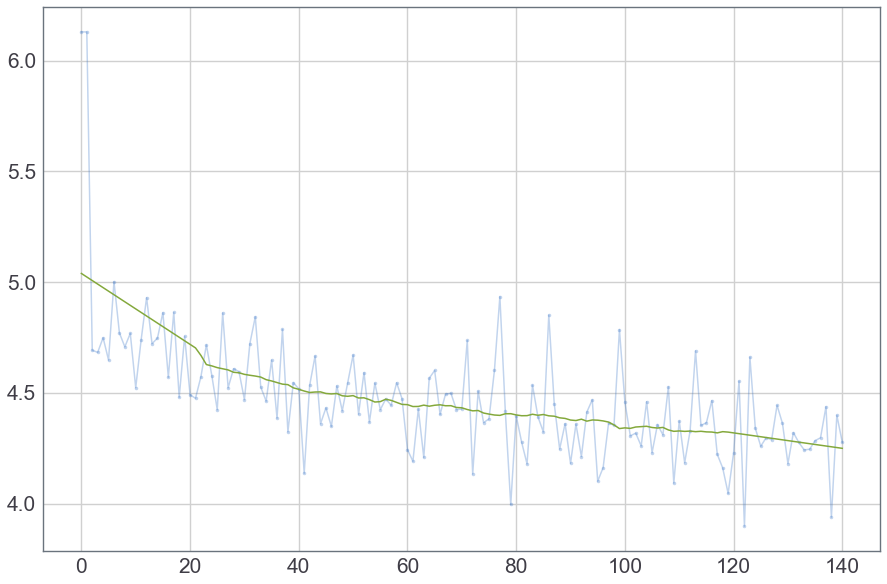

In [28]:
smooth_plot(history['loss'], remove_outlier=False)